In [67]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/us-consumer-finance-complaints/database.sqlite
/kaggle/input/us-consumer-finance-complaints/consumer_complaints.csv


In [68]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import sklearn.feature_extraction.text as text


from textblob import TextBlob
from nltk.stem import PorterStemmer,SnowballStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.tokenize.toktok import ToktokTokenizer

from io import StringIO
import os
import string
import gensim
from gensim.models import Word2Vec
import itertools
import scipy
from scipy import spatial
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks", color_codes=True)
plt.rcParams["figure.figsize"] = (20,15)
import re
import nltk
tokenizer = ToktokTokenizer()
stopword_list = nltk.corpus.stopwords.words('english')
import warnings
warnings.filterwarnings("ignore")

In [69]:
# Download stop words
nltk.download('stopwords')
# Download wordnet
nltk.download('wordnet')
missing_values = ["n/a", "na", "--", "?", " ", "-", "[]"]
df = pd.read_csv('../input/us-consumer-finance-complaints/consumer_complaints.csv', na_values = missing_values)
df.columns = df.columns.str.upper()
features = ['COMPLAINT_ID','DATE_RECEIVED','PRODUCT','ISSUE',
                              'COMPANY','STATE','SUBMITTED_VIA','COMPANY_RESPONSE_TO_CONSUMER','TIMELY_RESPONSE',
                              'CONSUMER_DISPUTED?','CONSUMER_COMPLAINT_NARRATIVE']
df1 = df[features]
df1 = df1[pd.notnull(df1['CONSUMER_COMPLAINT_NARRATIVE'])].reset_index().drop(columns = ['index'])

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# Consumer complaint narrative (TEXT PREPROCESSING)

In [70]:
#converting to lowercase
df1['CONSUMER_COMPLAINT_NARRATIVE'] =df1['CONSUMER_COMPLAINT_NARRATIVE'].apply(lambda x: ' '.join([i.lower() for i in x.split()]))
#removing puncuations
df1['CONSUMER_COMPLAINT_NARRATIVE'] =df1['CONSUMER_COMPLAINT_NARRATIVE'].str.replace(r'[^\w\s]',"")
#Removing xx's
df1['CONSUMER_COMPLAINT_NARRATIVE'] = df1['CONSUMER_COMPLAINT_NARRATIVE'].str.replace(r"xx+\s","")
#Removing stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')
df1['CONSUMER_COMPLAINT_NARRATIVE'] =df1['CONSUMER_COMPLAINT_NARRATIVE'].apply(lambda x: ' '.join([i for i in x.split() if i not in stop]))
#Lemmatizing
from textblob import Word
df1['CONSUMER_COMPLAINT_NARRATIVE'] =df1['CONSUMER_COMPLAINT_NARRATIVE'].apply(lambda x:' '.join([Word(i).lemmatize() for i in x.split()]))

In [71]:
#Using consumer narrative to predict Timely response
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(df1['CONSUMER_COMPLAINT_NARRATIVE'], df1['PRODUCT'],stratify=df1['TIMELY_RESPONSE'], 
                                                    test_size=0.3)

In [72]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D, Conv1D, SimpleRNN
from keras.models import Model
from keras.models import Sequential
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.layers import Dense, Input, Flatten, Dropout, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.models import Sequential

In [73]:
total_complaints = np.append(train_x.values,valid_x.values)
tokenizer = Tokenizer(num_words=25000)
tokenizer.fit_on_texts(train_x.values)
train_sequences = tokenizer.texts_to_sequences(train_x.values)
test_sequences = tokenizer.texts_to_sequences(valid_x.values)
word_index = tokenizer.word_index# dictionary containing words and their index
print('Found %s unique tokens.' % len(word_index))
MAX_SEQUENCE_LENGTH = max([len(c.split()) for c in total_complaints])
MAX_SEQUENCE_LENGTH

Found 52763 unique tokens.


393

In [74]:
train_data = pad_sequences(train_sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
test_data = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='post')
print(train_data.shape)
print(test_data.shape)

(46764, 393)
(20042, 393)


In [75]:
from sklearn import preprocessing
enc = preprocessing.LabelEncoder()
train_labels = enc.fit_transform(train_y)
test_labels = enc.fit_transform(valid_y)
print(enc.classes_)
print(np.unique(train_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))
labels_train = to_categorical(np.asarray(train_labels))
labels_test = to_categorical(np.asarray(test_labels))
print('Shape of data tensor:', train_data.shape)
print('Shape of label tensor:', labels_train.shape)
print('Shape of label tensor:', labels_test.shape)

['Bank account or service' 'Consumer Loan' 'Credit card'
 'Credit reporting' 'Debt collection' 'Money transfers' 'Mortgage'
 'Other financial service' 'Payday loan' 'Prepaid card' 'Student loan']
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([ 4018,  2599,  5604,  8721, 12295,   469, 10369,    84,   505,
         595,  1505]))
(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10]), array([1693, 1079, 2325, 3805, 5257,  197, 4550,   26,  221,  266,  623]))
Shape of data tensor: (46764, 393)
Shape of label tensor: (46764, 11)
Shape of label tensor: (20042, 11)


# CNN w/ Pre-trained word embeddings(GloVe), We’ll use pre-trained embeddings such as Glove which provides word based vector representation trained on a large corpus. It is trained on a dataset of one billion tokens (words) with a vocabulary of 400 thousand words. The glove has embedding vector sizes, including 50, 100, 200 and 300 dimensions.

In [76]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip

In [77]:
import zipfile
UNZIP_PATH = './'
with zipfile.ZipFile(UNZIP_PATH + 'glove.6B.zip', 'r') as zip_ref:
    zip_ref.extractall('./glove_data.zip')

In [78]:
# !wget http://nlp.stanford.edu/data/glove.6B.zip
GLOVE_DIR = './glove_data.zip'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [79]:
# Now lets create the embedding matrix using the word indexer created from tokenizer.
EMBEDDING_DIM = 300
embedding_matrix = np.zeros((len(word_index) + 1, EMBEDDING_DIM))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [94]:
#Lets check the word embedded vector representation for token ‘loan’ in our embedding matrix
[(k,v) for k,v in word_index.items() if v==4]

[('loan', 4)]

In [96]:
len(embedding_matrix[4])

300

In [97]:
vocab_size = len(tokenizer.word_index)+1
vocab_size

52764

In [82]:
import keras.backend as K
import tensorflow as tf
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True))
model.add(Dropout(0.3))
model.add(Conv1D(128, 5, activation="relu"))
model.add(MaxPooling1D(5))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Conv1D(64, 5, activation="relu"))
model.add(MaxPooling1D(5))
model.add(Dropout(0.3))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(11, activation="softmax"))
model.compile(loss='categorical_crossentropy',
 optimizer="rmsprop",
 metrics=[get_f1])
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 393, 300)          15829200  
_________________________________________________________________
dropout_12 (Dropout)         (None, 393, 300)          0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 389, 128)          192128    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 77, 128)           0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 77, 128)           0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 77, 128)           512       
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 73, 64)           

In [83]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('cnn_pretrained.h5', verbose=1, save_best_only=True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')]
history = model.fit(train_data, labels_train,batch_size=64,epochs=5,validation_split=0.3, callbacks=callbacks)

Epoch 1/5
512/512 [==============================] - 61s 114ms/step - loss: 1.4637 - get_f1: 0.4341 - val_loss: 0.7588 - val_get_f1: 0.7617
Epoch 2/5
512/512 [==============================] - 60s 117ms/step - loss: 0.7524 - get_f1: 0.7668 - val_loss: 0.6220 - val_get_f1: 0.8143
Epoch 3/5
512/512 [==============================] - 59s 116ms/step - loss: 0.6200 - get_f1: 0.8085 - val_loss: 0.5790 - val_get_f1: 0.8289
Epoch 4/5
512/512 [==============================] - 60s 118ms/step - loss: 0.5445 - get_f1: 0.8341 - val_loss: 0.5684 - val_get_f1: 0.8309
Epoch 5/5
512/512 [==============================] - 61s 120ms/step - loss: 0.5009 - get_f1: 0.8469 - val_loss: 0.5522 - val_get_f1: 0.8397


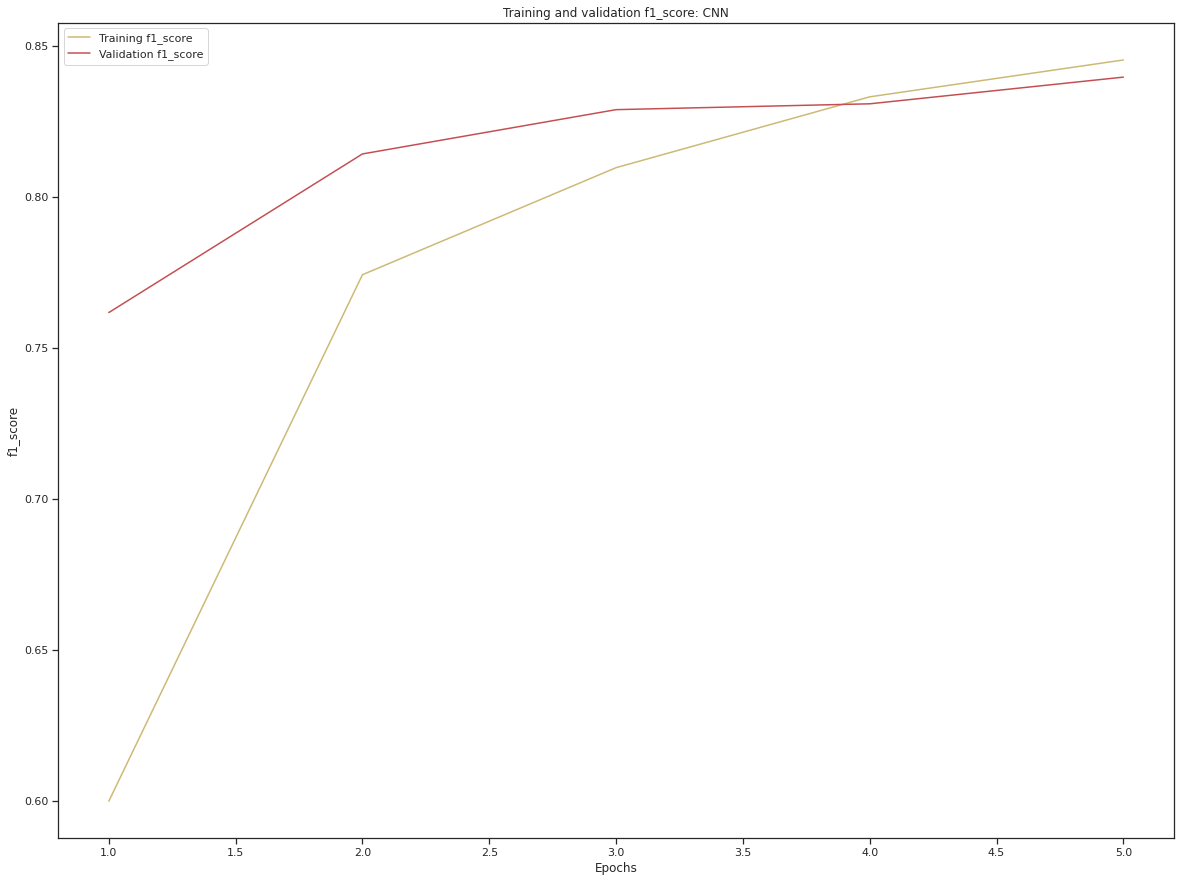

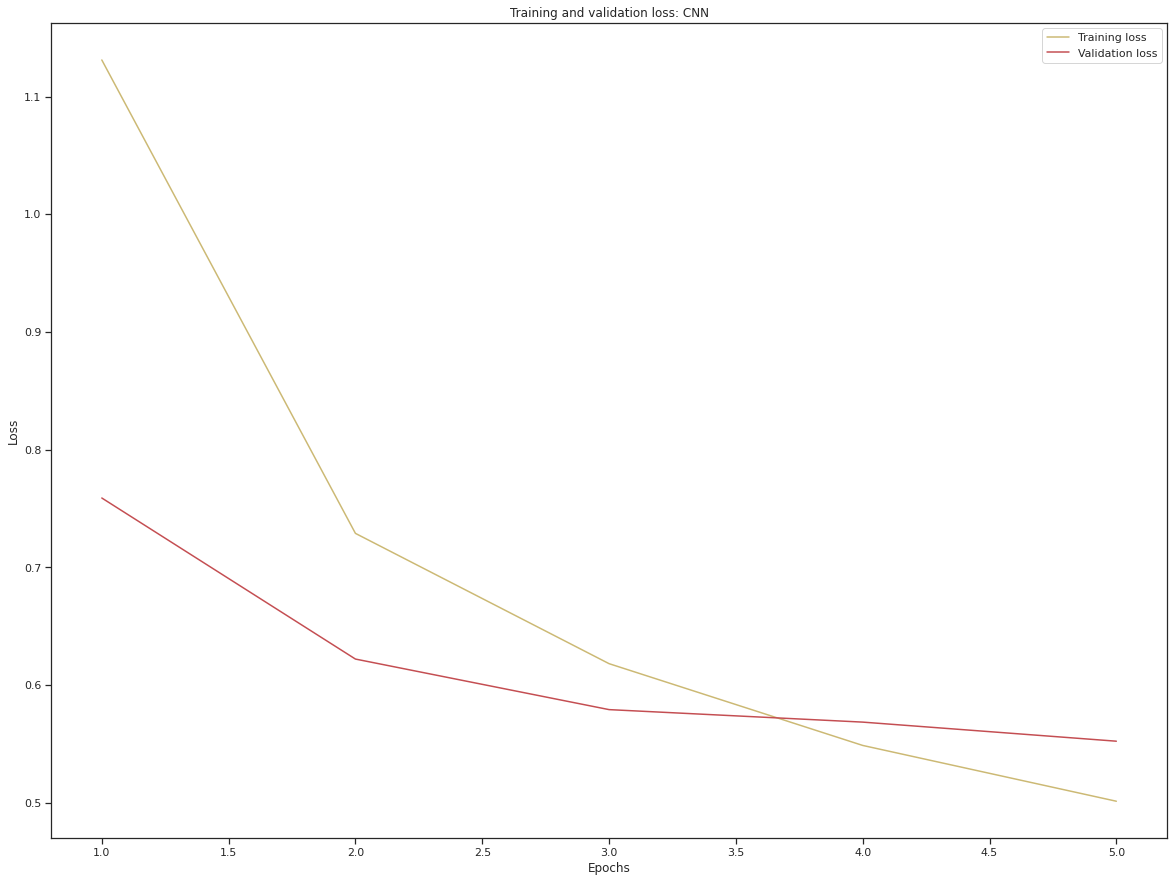

In [84]:
#plot the training and validation accuracy and loss at each epoch
f1_score = history.history['get_f1']
val_f1_score = history.history['val_get_f1']
epochs = range(1, len(f1_score) + 1)
plt.plot(epochs, f1_score, 'y', label='Training f1_score')
plt.plot(epochs, val_f1_score, 'r', label='Validation f1_score')
plt.title('Training and validation f1_score: CNN')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend()
plt.show()



loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss: CNN')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [85]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
predicted=model.predict(test_data)
print(classification_report(labels_test, predicted.round()))

              precision    recall  f1-score   support

           0       0.86      0.72      0.78      1693
           1       0.84      0.55      0.67      1079
           2       0.81      0.83      0.82      2325
           3       0.93      0.77      0.84      3805
           4       0.86      0.84      0.85      5257
           5       0.80      0.40      0.53       197
           6       0.94      0.93      0.94      4550
           7       0.00      0.00      0.00        26
           8       0.53      0.17      0.25       221
           9       0.74      0.69      0.72       266
          10       0.84      0.84      0.84       623

   micro avg       0.88      0.81      0.84     20042
   macro avg       0.74      0.61      0.66     20042
weighted avg       0.88      0.81      0.84     20042
 samples avg       0.81      0.81      0.81     20042



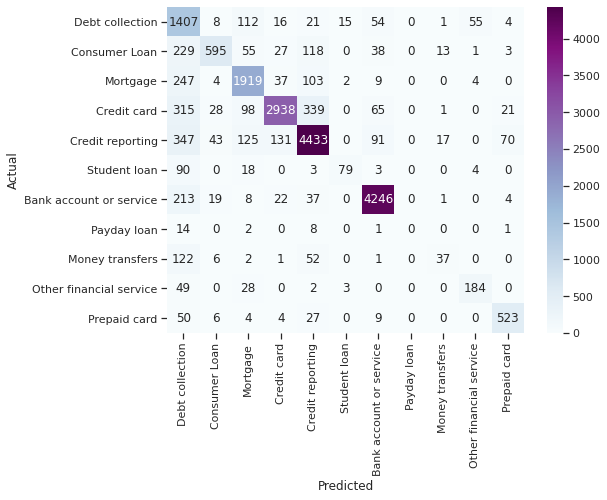

In [86]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(labels_test.argmax(axis=1), predicted.round().argmax(axis=1))
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=df1['PRODUCT'].unique(),yticklabels=df1['PRODUCT'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [87]:
#Bidirectional LSTM

model = Sequential()
model.add(Embedding(len(word_index) + 1,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True))
model.add(Bidirectional(LSTM(100, dropout= 0.2)))
model.add(Dense(11,activation='softmax'))
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=[get_f1])

In [88]:
#Modelcheckpoint
checkpointer = tf.keras.callbacks.ModelCheckpoint('rnn_lstm.h5', verbose=1, save_best_only=True)
callbacks = [tf.keras.callbacks.EarlyStopping(patience=2, monitor='val_loss')]
results = model.fit(train_data, labels_train,batch_size=100,epochs=3,validation_split=0.3, callbacks=callbacks)

Epoch 1/3
328/328 [==============================] - 53s 153ms/step - loss: 1.0868 - get_f1: 0.5801 - val_loss: 0.6706 - val_get_f1: 0.7871
Epoch 2/3
328/328 [==============================] - 50s 152ms/step - loss: 0.5547 - get_f1: 0.8270 - val_loss: 0.5869 - val_get_f1: 0.8109
Epoch 3/3
328/328 [==============================] - 50s 151ms/step - loss: 0.4432 - get_f1: 0.8622 - val_loss: 0.5189 - val_get_f1: 0.8371


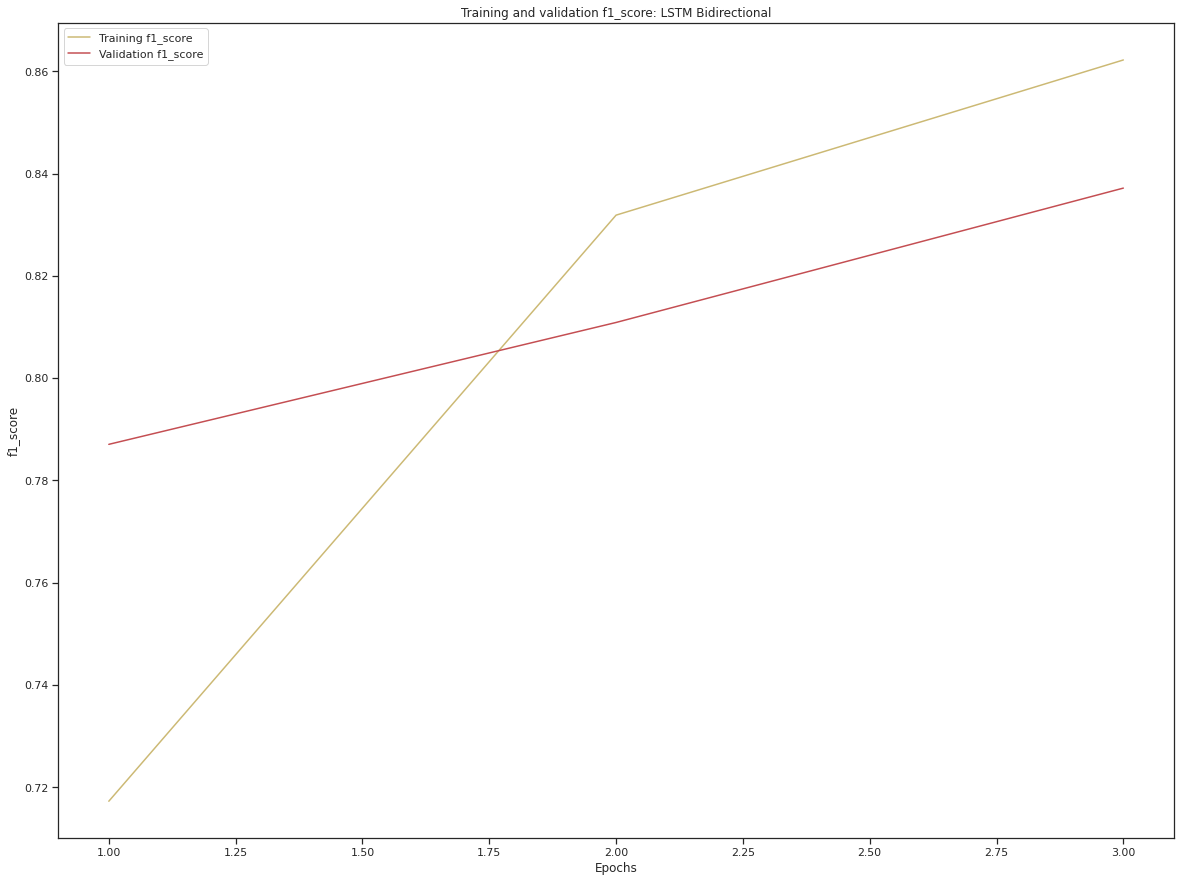

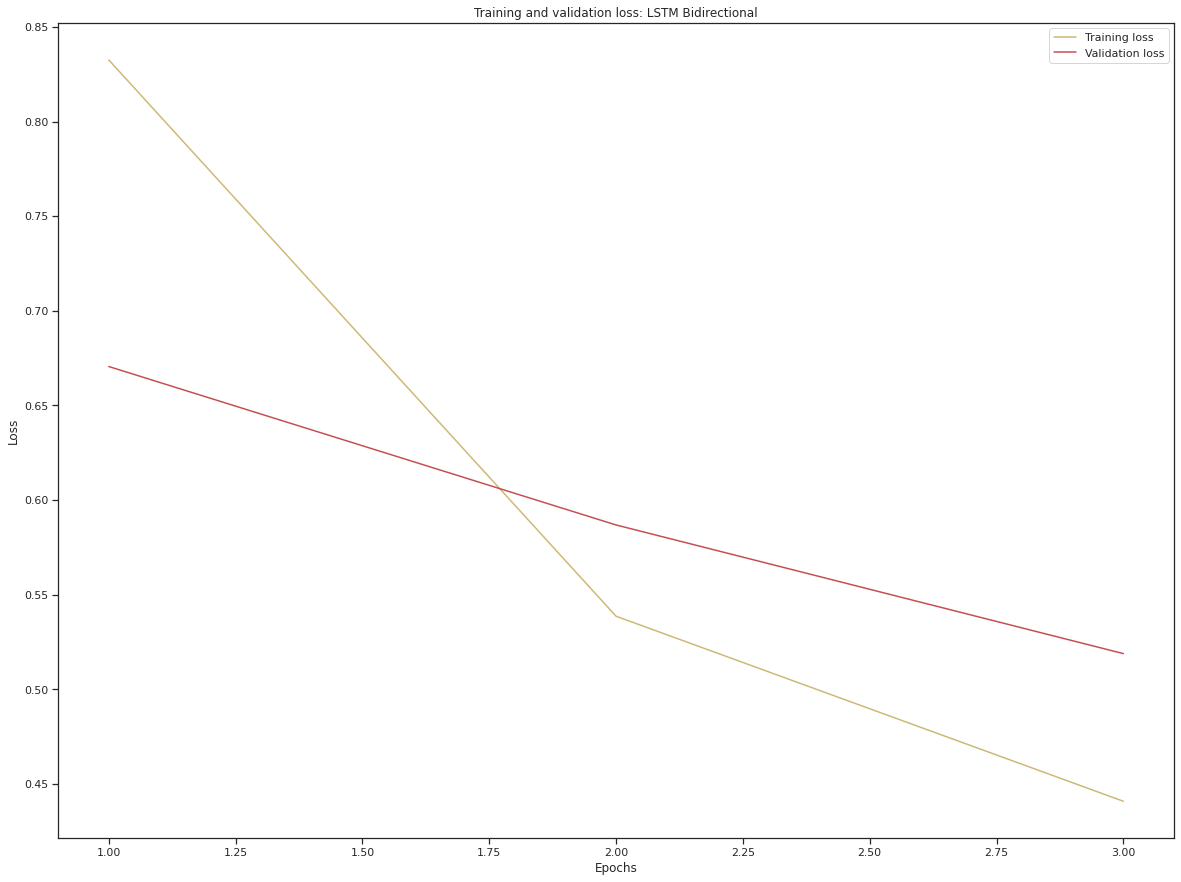

In [98]:
#plot the training and validation accuracy and loss at each epoch
f1_score = results.history['get_f1']
val_f1_score = results.history['val_get_f1']
epochs = range(1, len(f1_score) + 1)
plt.plot(epochs, f1_score, 'y', label='Training f1_score')
plt.plot(epochs, val_f1_score, 'r', label='Validation f1_score')
plt.title('Training and validation f1_score: LSTM Bidirectional')
plt.xlabel('Epochs')
plt.ylabel('f1_score')
plt.legend()
plt.show()



loss = results.history['loss']
val_loss = results.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss: LSTM Bidirectional')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [90]:
from sklearn.metrics import f1_score, confusion_matrix, classification_report
predicted=model.predict(test_data)
print(classification_report(labels_test, predicted.round()))

              precision    recall  f1-score   support

           0       0.81      0.78      0.79      1693
           1       0.78      0.60      0.68      1079
           2       0.91      0.63      0.74      2325
           3       0.91      0.81      0.86      3805
           4       0.83      0.89      0.86      5257
           5       0.57      0.64      0.60       197
           6       0.96      0.91      0.93      4550
           7       0.00      0.00      0.00        26
           8       0.63      0.30      0.41       221
           9       0.82      0.42      0.56       266
          10       0.84      0.84      0.84       623

   micro avg       0.87      0.81      0.84     20042
   macro avg       0.73      0.62      0.66     20042
weighted avg       0.87      0.81      0.83     20042
 samples avg       0.81      0.81      0.81     20042



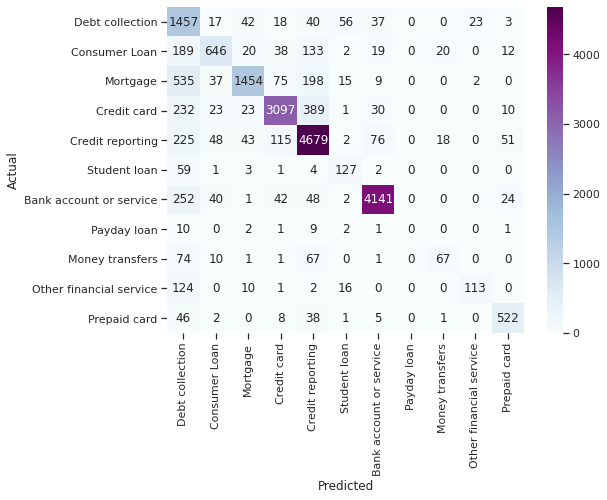

In [91]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(labels_test.argmax(axis=1), predicted.round().argmax(axis=1))
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="BuPu",xticklabels=df1['PRODUCT'].unique(),yticklabels=df1['PRODUCT'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()